<p style="text-align: center; font-size: 30px;">
    <strong>
          Análisis de reseñas comerciales de Amazon
    </strong>
</p>


<b style="text-align: left; font-size: 18px;">
    Este proyecto tiene como objetivo el análisis de las reseñas en Amazon.es
</b>

----

<b style="font-size: 20px;">Descripción del proyecto</b>

-  <p style="font-size: 18px;">Limpieza de la base de datos recaudada</p>
-  <p style="font-size: 18px;">Análisis de sentimiento</p>
---

<b style="font-size: 20px;">Preinstalaciones</b>

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Biblioteca Langdetect para extraer reseñas no españolas  
</blockquote>

In [4]:
!pip install langdetect

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Biblioteca Pandas para almacenamiento y manipulación de datos 
</blockquote>

In [6]:
!pip install pandas

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Biblioteca TQDM para visualización del progreso 
</blockquote>

In [8]:
!pip install tqdm

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Biblioteca Spacy para el procesamiento del lenguaje natural
</blockquote>

In [46]:
!pip install spacy
!python -m spacy download es_core_news_md
!pip install emoji 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 72.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Herramienta TextBlob
</blockquote>

In [12]:
!pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 20.7 MB/s eta 0:00:00


<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Herramienta PySentimiento
</blockquote>

In [14]:
!pip install pysentimiento

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Matplotlib para visualizar los resultados (gráficos)
</blockquote>

In [16]:
!pip install matplotlib

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Transformers para pipeline (para trabajar con modelos basados en Transformer architecture)
</blockquote>

In [18]:
!pip install transformers

---
<b style="font-size: 20px;">Importaciones </b>

In [155]:
from langdetect import detect
from textblob import TextBlob
from pysentimiento import create_analyzer
from transformers import pipeline
import spacy

import re
import emoji

import pandas as pd
from tqdm import tqdm
import os

from IPython.display import display, HTML
import matplotlib.pyplot as plt

import time
import datetime

---
<b style="font-size: 20px;">
    Limpieza de las reseñas de otros idiomas
</b>

In [167]:
from tqdm import tqdm

def is_spanish(text):
    try:
        return detect(text) == 'es'
    except: #en caso de error o idioma no detectado
        return False

def filter_reseñas_esp(filename):
    df = pd.read_csv(filename)
    count_original = df.shape[0]
    
    filtered_df = df[df["body"].apply(is_spanish)]
    count_final = filtered_df.shape[0]

    if count_final > 0:
        filtered_df.to_csv(filename, index=False, encoding="utf-8")
    else:
        df.head(0).to_csv(filename, index=False, encoding="utf-8")

    diff = count_original - count_final 
    return (filtered_df, diff)

if __name__ == "__main__":
    base_df = pd.read_csv('new_database/base.csv')

    dataframes = []

    for ID in base_df['ID']:
        id_df = pd.read_csv(f'new_database/{ID}.csv')
        category = base_df.loc[base_df['ID'] == ID, 'category'].values

        reviews_df = pd.DataFrame()

        for local_id in tqdm(id_df['ID'], desc=f"Processing local_IDs for {ID}.csv"):
            review_filename = f'new_database/reviews/{local_id}.csv'
        
            (filtered_df, count) = filter_reseñas_esp(review_filename)

            reviews_df = pd.concat([reviews_df, filtered_df], ignore_index=True)
        
        print('-'*50 + f'\nReviews left in the {category[0]} category: {reviews_df.shape[0]}\n')
        dataframes.append(reviews_df)

    for i in range(len(dataframes)):
        dataframes[i].to_csv(f'reviews_cleaned_{i}.csv', index = False, encoding = "utf-8")

Processing local_IDs for 0.csv: 100%|█████████| 279/279 [00:35<00:00,  7.87it/s]


--------------------------------------------------
Reviews left in the Cafeteras de goteo category: 20442



Processing local_IDs for 1.csv: 100%|███████████| 98/98 [00:29<00:00,  3.37it/s]


--------------------------------------------------
Reviews left in the Cafeteras automaticas category: 16052



Processing local_IDs for 2.csv: 100%|█████████| 148/148 [00:31<00:00,  4.65it/s]


--------------------------------------------------
Reviews left in the Cafeteras individuales category: 19023



In [14]:
base_df = pd.read_csv('new_database/base.csv')
all_reviews = pd.DataFrame()

for ID in base_df['ID']:
    id_df = pd.read_csv(f'new_database/{ID}.csv')
    category = base_df.loc[base_df['ID'] == ID, 'category'].values
    
    reviews_df = pd.DataFrame()
    
    for local_id in id_df['ID']:
        review_file = f'new_database/reviews/{local_id}.csv'
        
        if os.path.exists(review_file):
            try:
                review_df = pd.read_csv(review_file)
            except:
                print(f'Error parsing {review_file}')
                continue
            reviews_df = pd.concat([reviews_df, review_df], ignore_index=True)
    
    print(f'Located {len(reviews_df)} reviews in {category[0]} category.')

    all_reviews = pd.concat([all_reviews, reviews_df], ignore_index=True)

print('-'*50 + f'\nTotal number of reviews in the new_database: {len(all_reviews)}\n' + '-'*50)

all_reviews.head()

Located 20495 reviews in Cafeteras de goteo category.
Located 16073 reviews in Cafeteras automaticas category.
Located 19085 reviews in Cafeteras individuales category.
--------------------------------------------------
Total number of reviews in the new_database: 55653
--------------------------------------------------


,title,rating,body,author,date
0,Regalo,"5,0 de 5 estrellas",Me gustó mucho,Cliente Amazon,Revisado en España el 6 de abril de 2024
1,No ha durado ni la garantía + pésimo servicio ...,"1,0 de 5 estrellas","Ni los 24 meses de garantía ha durado, y al en...",MaX,Revisado en España el 3 de abril de 2024
2,Está bien,"3,0 de 5 estrellas",Después de más de dos meses usándola hace muy ...,Lorena,Revisado en España el 14 de marzo de 2024
3,Perfecta!,"5,0 de 5 estrellas",Me encanta! Soy adicta al café y me gusta toma...,Perfecta!,Revisado en España el 22 de febrero de 2024
4,EXCELENTE,"5,0 de 5 estrellas",como única pega que limpiar el palito del vapo...,Sil at,Revisado en España el 20 de febrero de 2024


In [161]:
#Salida de reseñas detectadas como españolas, mostrar primeras cinco reseñas

dataframes = []
for i in range (3): 
    dataframes.append(pd.read_csv(f"Langdetect_categories/category_{i}.csv"))
dataframes[0].head()

,title,rating,body,author,date
0,Regalo,"5,0 de 5 estrellas",Me gustó mucho,Cliente Amazon,Revisado en España el 6 de abril de 2024
1,No ha durado ni la garantía + pésimo servicio ...,"1,0 de 5 estrellas","Ni los 24 meses de garantía ha durado, y al en...",MaX,Revisado en España el 3 de abril de 2024
2,Está bien,"3,0 de 5 estrellas",Después de más de dos meses usándola hace muy ...,Lorena,Revisado en España el 14 de marzo de 2024
3,Perfecta!,"5,0 de 5 estrellas",Me encanta! Soy adicta al café y me gusta toma...,Perfecta!,Revisado en España el 22 de febrero de 2024
4,EXCELENTE,"5,0 de 5 estrellas",como única pega que limpiar el palito del vapo...,Sil at,Revisado en España el 20 de febrero de 2024


<b style="font-size: 20px;">
    Limpieza de la base de datos
</b>

In [163]:
#Comando para quitar puntuación en el texto

def quitar_puntuacion(texto):
  puntuacion = '¡!"$%&\'()*+,-./:;<=>¿?[\]^_`{|}~'
  return re.sub('[%s]' % re.escape(puntuacion), ' ', texto)

#Ejemplo de quitar puntuación

quitar_puntuacion("¡hola! ¿que tal? +no puedo venir, pero te envío un regalo")

<>:4: SyntaxWarning: invalid escape sequence '\]'
<>:4: SyntaxWarning: invalid escape sequence '\]'
/var/folders/yz/8sxcfyl57n5459dd5zkccpnh0000gq/T/ipykernel_12331/1248366481.py:4: SyntaxWarning: invalid escape sequence '\]'
  puntuacion = '¡!"$%&\'()*+,-./:;<=>¿?[\]^_`{|}~'


' hola   que tal   no puedo venir  pero te envío un regalo'

In [168]:
#Quitar puntuación en reseñas filtradas

filtered_df['body'] = filtered_df['body'].apply(quitar_puntuacion)
for i in range (3): #recorre los 3 csvs que correspondes a las tres categorías de cafeteras
    dataframes[i]['body']= dataframes[i]['body'].apply(quitar_puntuacion)

In [169]:
#Resultado
dataframes[0].head()

,title,rating,body,author,date
0,Regalo,"5,0 de 5 estrellas",Me gustó mucho,Cliente Amazon,Revisado en España el 6 de abril de 2024
1,No ha durado ni la garantía + pésimo servicio ...,"1,0 de 5 estrellas",Ni los 24 meses de garantía ha durado y al en...,MaX,Revisado en España el 3 de abril de 2024
2,Está bien,"3,0 de 5 estrellas",Después de más de dos meses usándola hace muy ...,Lorena,Revisado en España el 14 de marzo de 2024
3,Perfecta!,"5,0 de 5 estrellas",Me encanta Soy adicta al café y me gusta toma...,Perfecta!,Revisado en España el 22 de febrero de 2024
4,EXCELENTE,"5,0 de 5 estrellas",como única pega que limpiar el palito del vapo...,Sil at,Revisado en España el 20 de febrero de 2024


In [173]:
#Comando para quitar acentos gráficos

def normalizar_tildes(texto):
    a = 'áàäâ'
    e = 'éèëê'
    i = 'íìïî'
    o = 'óòöô'
    u = 'úùüû'
    texto_normal = re.sub('[%s]' % re.escape(a), 'a', texto)
    texto_normal = re.sub('[%s]' % re.escape(e), 'e', texto_normal)
    texto_normal = re.sub('[%s]' % re.escape(i), 'i', texto_normal)
    texto_normal = re.sub('[%s]' % re.escape(o), 'o', texto_normal)
    texto_normal = re.sub('[%s]' % re.escape(u), 'u', texto_normal)
    return texto_normal

#Ejemplo de quitar acentos gráficos

normalizar_tildes ("Cómo lo habéis pasado, sí ,qué")

'Como lo habeis pasado, si ,que'

In [175]:
#Quitar acentos gráficos en reseñas filtradas

filtered_df['body'] = filtered_df['body'].apply(normalizar_tildes)
for i in range (3):
    dataframes[i]['body']= dataframes[i]['body'].apply(normalizar_tildes)

In [177]:
#Resultado
dataframes[0].head()

,title,rating,body,author,date
0,Regalo,"5,0 de 5 estrellas",Me gusto mucho,Cliente Amazon,Revisado en España el 6 de abril de 2024
1,No ha durado ni la garantía + pésimo servicio ...,"1,0 de 5 estrellas",Ni los 24 meses de garantia ha durado y al en...,MaX,Revisado en España el 3 de abril de 2024
2,Está bien,"3,0 de 5 estrellas",Despues de mas de dos meses usandola hace muy ...,Lorena,Revisado en España el 14 de marzo de 2024
3,Perfecta!,"5,0 de 5 estrellas",Me encanta Soy adicta al cafe y me gusta toma...,Perfecta!,Revisado en España el 22 de febrero de 2024
4,EXCELENTE,"5,0 de 5 estrellas",como unica pega que limpiar el palito del vapo...,Sil at,Revisado en España el 20 de febrero de 2024


In [179]:
#Comando para sustituir mayúsculas por minúsculas

def sustituir_minusculas(texto):
    texto_letras_min = texto.lower()
    return texto_letras_min

#Ejemplo de sustituir mayúsculas por minúsculas

sustituir_minusculas ("QuieRo Ver La TeLE")

'quiero ver la tele'

In [181]:
#Sustituir mayúsculas por minúsculas en reseñas filtradas

filtered_df['body'] = filtered_df['body'].apply(sustituir_minusculas)
for i in range (3):
    dataframes[i]['body']= dataframes[i]['body'].apply(sustituir_minusculas)

In [183]:
#Resultado
dataframes[0].head()

,title,rating,body,author,date
0,Regalo,"5,0 de 5 estrellas",me gusto mucho,Cliente Amazon,Revisado en España el 6 de abril de 2024
1,No ha durado ni la garantía + pésimo servicio ...,"1,0 de 5 estrellas",ni los 24 meses de garantia ha durado y al en...,MaX,Revisado en España el 3 de abril de 2024
2,Está bien,"3,0 de 5 estrellas",despues de mas de dos meses usandola hace muy ...,Lorena,Revisado en España el 14 de marzo de 2024
3,Perfecta!,"5,0 de 5 estrellas",me encanta soy adicta al cafe y me gusta toma...,Perfecta!,Revisado en España el 22 de febrero de 2024
4,EXCELENTE,"5,0 de 5 estrellas",como unica pega que limpiar el palito del vapo...,Sil at,Revisado en España el 20 de febrero de 2024


In [185]:
#Comando para quitar números

def quitar_numeros(texto):
    texto_sin_numeros = re.sub(r'\d+', '', texto)
    return texto_sin_numeros

#Ejemplo de quitar números

quitar_numeros ("He comprado 2 cafeteras, la 1 funcionó solo 24 horas")

'He comprado  cafeteras, la  funcionó solo  horas'

In [187]:
#Quitar números en reseñas filtradas

filtered_df['body'] = filtered_df['body'].apply(quitar_numeros)
for i in range (3):
    dataframes[i]['body']= dataframes[i]['body'].apply(quitar_numeros)

In [189]:
#Resultado
dataframes[0].head()

,title,rating,body,author,date
0,Regalo,"5,0 de 5 estrellas",me gusto mucho,Cliente Amazon,Revisado en España el 6 de abril de 2024
1,No ha durado ni la garantía + pésimo servicio ...,"1,0 de 5 estrellas",ni los meses de garantia ha durado y al envi...,MaX,Revisado en España el 3 de abril de 2024
2,Está bien,"3,0 de 5 estrellas",despues de mas de dos meses usandola hace muy ...,Lorena,Revisado en España el 14 de marzo de 2024
3,Perfecta!,"5,0 de 5 estrellas",me encanta soy adicta al cafe y me gusta toma...,Perfecta!,Revisado en España el 22 de febrero de 2024
4,EXCELENTE,"5,0 de 5 estrellas",como unica pega que limpiar el palito del vapo...,Sil at,Revisado en España el 20 de febrero de 2024


In [191]:
#Comando para quitar emojis con UNICODE

import regex as re    #regex para encontrar emojis
def quitar_emojis(texto):
    emoji_pattern = re.compile(
        u'['
        u'\U0001F600-\U0001F64F'  # Emoticonos
        u'\U0001F300-\U0001F5FF'  # Símbolos y pictogramas
        u'\U0001F680-\U0001F6FF'  # Transporte y símbolos de mapa
        u'\U0001F700-\U0001F77F'  # Símbolos alchemicos
        u'\U0001F780-\U0001F7FF'  # Símbolos geométricos adicionales
        u'\U0001F800-\U0001F8FF'  # Símbolos adicionales de flechas
        u'\U0001F900-\U0001F9FF'  # Emojis adicionales
        u'\U0001FA00-\U0001FA6F'  # Más emojis adicionales
        u'\U0001FA70-\U0001FAFF'  # Más emojis adicionales
        u'\U00002702-\U000027B0'  # Símbolos de soporte
        u'\U000024C2-\U0001F251'
        u']+', flags=re.UNICODE)

    texto_sin_emoji = re.sub(emoji_pattern, '', texto)
    return texto_sin_emoji

#Ejemplo de quitar emojis

quitar_emojis("No me vale 😆🐻🤣😂porque👌🙂🚑, soy de 🇪🇸, además ❤️➡️")

'No me vale porque, soy de , además '

In [193]:
#Quitar emojis en reseñas filtradas

filtered_df['body'] = filtered_df['body'].apply(quitar_emojis)
for i in range (3):
    dataframes[i]['body']= dataframes[i]['body'].apply(quitar_emojis)

In [195]:
#Resultado
dataframes[0].head()

,title,rating,body,author,date
0,Regalo,"5,0 de 5 estrellas",me gusto mucho,Cliente Amazon,Revisado en España el 6 de abril de 2024
1,No ha durado ni la garantía + pésimo servicio ...,"1,0 de 5 estrellas",ni los meses de garantia ha durado y al envi...,MaX,Revisado en España el 3 de abril de 2024
2,Está bien,"3,0 de 5 estrellas",despues de mas de dos meses usandola hace muy ...,Lorena,Revisado en España el 14 de marzo de 2024
3,Perfecta!,"5,0 de 5 estrellas",me encanta soy adicta al cafe y me gusta toma...,Perfecta!,Revisado en España el 22 de febrero de 2024
4,EXCELENTE,"5,0 de 5 estrellas",como unica pega que limpiar el palito del vapo...,Sil at,Revisado en España el 20 de febrero de 2024


In [197]:
#Comando para quitar links

def quitar_links(texto):
    regex= r"http\S+"
    texto = re.sub(regex,"",texto)
    return texto

#Ejemplo quitar links

quitar_links ("Mira aquí https://www.zalando.es/mujer-home/")

'Mira aquí '

In [199]:
#Quitar links en reseñas filtradas

filtered_df['body'] = filtered_df['body'].apply(quitar_links)
for i in range (3):
    dataframes[i]['body']= dataframes[i]['body'].apply(quitar_links)

In [201]:
#Resultado
dataframes[0].head()

,title,rating,body,author,date
0,Regalo,"5,0 de 5 estrellas",me gusto mucho,Cliente Amazon,Revisado en España el 6 de abril de 2024
1,No ha durado ni la garantía + pésimo servicio ...,"1,0 de 5 estrellas",ni los meses de garantia ha durado y al envi...,MaX,Revisado en España el 3 de abril de 2024
2,Está bien,"3,0 de 5 estrellas",despues de mas de dos meses usandola hace muy ...,Lorena,Revisado en España el 14 de marzo de 2024
3,Perfecta!,"5,0 de 5 estrellas",me encanta soy adicta al cafe y me gusta toma...,Perfecta!,Revisado en España el 22 de febrero de 2024
4,EXCELENTE,"5,0 de 5 estrellas",como unica pega que limpiar el palito del vapo...,Sil at,Revisado en España el 20 de febrero de 2024


In [203]:
#Comando para quitar unas abreviaciones

def quitar_abr(texto):
    ques = r"\sq\s|\sqe\s|\sk\s|\Sq\s|\Sqe\s|\Sk\s" #variaciones de que
    tbs = r"\stbn|\stb|\Stbn|\Stb" #variaciones de también
    porques = r"xqe\s|pqe\s|porq\s|xq\s|pq\s|Xqe\s|Pqe\s|Porq\s|Xq\s|Pq\s" #variaciones de porque

    texto_sin_abr = re.sub(ques, ' que ', texto)
    texto_sin_abr = re.sub(tbs, ' tambien', texto_sin_abr)
    texto_sin_abr = re.sub(porques, ' porque ', texto_sin_abr)
    return texto_sin_abr

#Ejemplo de quitar abr

quitar_abr("Xq no sé pq no me gusta, porq nada, tbn he comrado una, tb a mi hermana")

' que no sé  que no me gusta, po que nada, tambien he comrado una, tambien a mi hermana'

In [205]:
#Quitar abreviacioes en reseñas filtradas

filtered_df['body'] = filtered_df['body'].apply(quitar_abr)
for i in range (3):
    dataframes[i]['body']= dataframes[i]['body'].apply(quitar_abr)

In [206]:
#Resultado
dataframes[0].head()

,title,rating,body,author,date
0,Regalo,"5,0 de 5 estrellas",me gusto mucho,Cliente Amazon,Revisado en España el 6 de abril de 2024
1,No ha durado ni la garantía + pésimo servicio ...,"1,0 de 5 estrellas",ni los meses de garantia ha durado y al envi...,MaX,Revisado en España el 3 de abril de 2024
2,Está bien,"3,0 de 5 estrellas",despues de mas de dos meses usandola hace muy ...,Lorena,Revisado en España el 14 de marzo de 2024
3,Perfecta!,"5,0 de 5 estrellas",me encanta soy adicta al cafe y me gusta toma...,Perfecta!,Revisado en España el 22 de febrero de 2024
4,EXCELENTE,"5,0 de 5 estrellas",como unica pega que limpiar el palito del vapo...,Sil at,Revisado en España el 20 de febrero de 2024


<b style="font-size: 20px;">
    Guardar la base de datos depurada 
</b>

In [ ]:
#Guardar los resultados en CSVs nuevos

for i in range (3):
    dataframes[i].to_csv(f"Categories_cleaned/reviews_cleaned_{i}.csv", index=False, encoding='utf-8')

----
<p style="text-align: center; font-size: 25px; margin-top: 20px;">
    <strong>
          Análisis de sentimiento
    </strong>
</p>

----


<b style="font-size: 20px;">
    Visualización de tablas y gráficos
</b>
<p style="font-size: 18px;">Definición de funciones para demostración de los resultados.</p>

In [102]:
def show_pie_chart(polarities):
    base = pd.read_csv("new_database/base.csv") # nombrar categorías
    categories = []
    
    for i in base["category"]:
        categories.append(i)

    labels = ['Positive', 'Neutral', 'Negative']
    fig, axis = plt.subplots(1, 3, figsize=(18, 6)) # crear a shape and an axis

    for i, (ax, data) in enumerate(zip(axis, polarities)):
        ax.pie(data, labels=labels, autopct='%1.1f%%', colors=['#66b3ff','#ffcc99','#ff6666'])
        ax.set_title(categories[i])

    plt.tight_layout() #showing diagrams
    plt.show()

def load_polarities_from_csv(type):
    polarities = []
    for i in range(3):
        
        df = pd.read_csv(f'Categories_cleaned_analyzed_sent/revievs_sentiment_{i}.csv')

        if type not in df.columns: # si la columna no existe
            raise ValueError(f"Column '{type}' does not exist in the DataFrame.")

        counts = df[type].value_counts() # contar el número de valores diferentes en esas columnas
    
        result = ( # convirtiéndolo en un cortejo 
            counts.get('POS', 0),
            counts.get('NEU', 0),
            counts.get('NEG', 0)
        )

        polarities.append(result)
    
    return polarities

def show_comparison():
    base = pd.read_csv("new_database/base.csv") # nombrar categorías
    categories = []
    
    for i in base["category"]:
        categories.append(i)

    for i in range(3):
        df = pd.read_csv(f'Categories_cleaned_analyzed_sent/revievs_sentiment_{i}.csv')
    
        # Localizar las cinco primeras palabras no coincidentes
        mismatched_reviews = df[df['Pysentimiento_sentiment'] != df['BERT_sentiment']].head(60)

        # Formar título 
        text = f"Mismatched results for {categories[i]} category"
        html_code = f"""
        <b style="font-size: 20px;  margin-bottom: 20px;">
            <h1 style="font-size: 25px; text-align: center;">{text}</h1>
        </b>
        """
        display(HTML(html_code))
    
        # Visualización de la tabla
        html_content = """
        <table style="width:100%; border-collapse: collapse; table-layout: auto;">
            <tr style="background-color: #f2f2f2; text-align: center;">
                <th style="border: 1px solid #dddddd; padding: 8px; text-align: center; width: 70%; font-size: 15px;">Review</th>
                <th style="border: 1px solid #dddddd; padding: 8px; text-align: center; width: 15%; font-size: 15px;">Pysentimiento Sentiment</th>
                <th style="border: 1px solid #dddddd; padding: 8px; text-align: center; width: 15%; font-size: 15px;">BERT Sentiment</th>
            </tr>
        """

        for index, row in mismatched_reviews.iterrows():
            html_content += f"""
            <tr>
                <td style="border: 1px solid #dddddd; padding: 8px; text-align: left;">{row['body']}</td>
                <td style="border: 1px solid #dddddd; padding: 8px; text-align: center;">{row['Pysentimiento_sentiment']}</td>
                <td style="border: 1px solid #dddddd; padding: 8px; text-align: center;">{row['BERT_sentiment']}</td>
            </tr>
            """

        html_content += "</table>"
    
        display(HTML(html_content))


---
<b style="font-size: 20px;">Primer método: TextBlob</b>

In [84]:
nlp = spacy.load('es_core_news_md')

def analyze_sentiment_TextBlob(review):
    doc = nlp(review) # tokenizer 
    
    processed_review = " ".join([token.text for token in doc]) # ajustar la tokenización para TextBlob

    blob = TextBlob(processed_review)
    
    polarity = blob.sentiment.polarity # obtener polaridad entre -1,0 y 1,0

    if polarity > 0:
        return 'POS' # positivo
    if polarity < 0:
        return 'NEG' # negativo
    
    return 'NEU' # neutral



if __name__ == "__main__":
    
    start_time = time.perf_counter() 
    
    for i in range(3):
        df = pd.read_csv(f'Categories_cleaned/reviews_cleaned_{i}.csv')

        
        for j in tqdm(range(df.shape[0]), desc = f"Classifying reviews in reviews_cleaned_{i}.csv"):
            polarity = analyze_sentiment_TextBlob(df.loc[j, 'body'])
            df.loc[j, 'TextBlob_sentiment'] = polarity

        df.to_csv(f'Categories_cleaned_analyzed_sent/revievs_sentiment_{i}.csv', index = False, encoding = "utf-8")

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print('-'*50 + f'\nTime taken: {str(datetime.timedelta(seconds = elapsed_time))}')

Classifying reviews in reviews_cleaned_0.csv: 100%|█| 20495/20495 [03:03<00:00, 
Classifying reviews in reviews_cleaned_1.csv: 100%|█| 16073/16073 [03:31<00:00, 
Classifying reviews in reviews_cleaned_2.csv: 100%|█| 19085/19085 [02:35<00:00, 


--------------------------------------------------
Time taken: 0:09:11.666972


---
<b style="font-size: 20px;">Segundo método: Pysentimiento</b>

In [86]:
analyzer = create_analyzer(task="sentiment", lang="es")
nlp = spacy.load('es_core_news_md')

def analyze_sentiment_py(text):
    doc = nlp(text) # tokenizing 
    
    processed_review = " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space]) # preparación y filtración
    result = analyzer.predict(processed_review)

    #max_label = max(result.probabilities, key=result.probabilities.get) # elegir el resultado con mayor probabilidad 
    max_label = result.output
    
    return max_label

if __name__ == "__main__":
    start_time = time.perf_counter() 

    for i in range(3):

        df = pd.read_csv(f'Categories_cleaned_analyzed_sent/revievs_sentiment_{i}.csv')
        
        for j in tqdm(range(df.shape[0]), desc = f"Classifying reviews in reviews_sentiment_{i}.csv"):
            polarity = analyze_sentiment_py(df.loc[j, 'body'])
            df.loc[j,'Pysentimiento_sentiment'] = polarity

        df.to_csv(f'Categories_cleaned_analyzed_sent/revievs_sentiment_{i}.csv', index = False, encoding = "utf-8")
                
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print('-'*50 + f'\nTime taken: {str(datetime.timedelta(seconds = elapsed_time))}')

/Applications/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Classifying reviews in reviews_sentiment_0.csv: 100%|█| 20495/20495 [22:04<00:00
Classifying reviews in reviews_sentiment_1.csv: 100%|█| 16073/16073 [19:35<00:00
Classifying reviews in reviews_sentiment_2.csv: 100%|█| 19085/19085 [21:02<00:00


--------------------------------------------------
Time taken: 1:02:42.128763


---
<b style="font-size: 20px;">Tercer método: modelo tipo BERT</b>

In [88]:
# Creación de una cadena de análisis de polaridad con BETO
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    #tokenizer_kwargs={"clean_up_tokenization_spaces": True}
)

def analyze_sentiment(review): # sólo viable para textos cortos (menos de 512 tokens)
    result = sentiment_analysis(review)[0]
    label = result['label']
    
    if label == '1 star' or label == '2 stars':
        return -1 
    elif label == '4 stars' or label == '5 stars':
        return 1
    else:
        return 0

def analyze_sentiment_long_text(review, chunk_size=512): # dividir los textos en trozos y hallar una polaridad media
    chunks = [review[i:i + chunk_size] for i in range(0, len(review), chunk_size)]
    sentiments = []
    
    for chunk in chunks:
        result = sentiment_analysis(chunk)[0]
        label = result['label']
        if label == '1 star' or label == '2 stars':
            sentiments.append(-1)  # Negativo
        elif label == '4 stars' or label == '5 stars':
            sentiments.append(1)  # Positivo
        else:
            sentiments.append(0)  # Neutral
    
    total = sum(sentiments) / len(sentiments)

    if total > 0:
        return 'POS'
    elif total < 0:
        return 'NEG'
    else:
        return 'NEU'

if __name__ == "__main__":

    start_time = time.perf_counter()
    
    polarities_df = pd.DataFrame(columns=["Positive", "Neutral", "Negative"])
    
    for i in range(3):
        df = pd.read_csv(f'Categories_cleaned_analyzed_sent/revievs_sentiment_{i}.csv')

        for j in tqdm(range(df.shape[0]), desc=f"Processing reviews in reviews_sentiment_{i}.csv"):
            polarity = analyze_sentiment_long_text(df.loc[j, 'body'])
            df.loc[j, 'BERT_sentiment'] = polarity

        df.to_csv(f'Categories_cleaned_analyzed_sent/revievs_sentiment_{i}.csv', index = False, encoding = "utf-8")

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print('-'*50 + f'\nTime taken: {str(datetime.timedelta(seconds = elapsed_time))}')

/Applications/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Processing reviews in reviews_sentiment_0.csv: 100%|█| 20495/20495 [20:53<00:00,
Processing reviews in reviews_sentiment_1.csv: 100%|█| 16073/16073 [20:13<00:00,
Processing reviews in reviews_sentiment_2.csv: 100%|█| 19085/19085 [16:35<00:00,


--------------------------------------------------
Time taken: 0:57:43.147530


---
<b style="font-size: 20px;">Visualización de los resultados de los métodos aplicados</b>

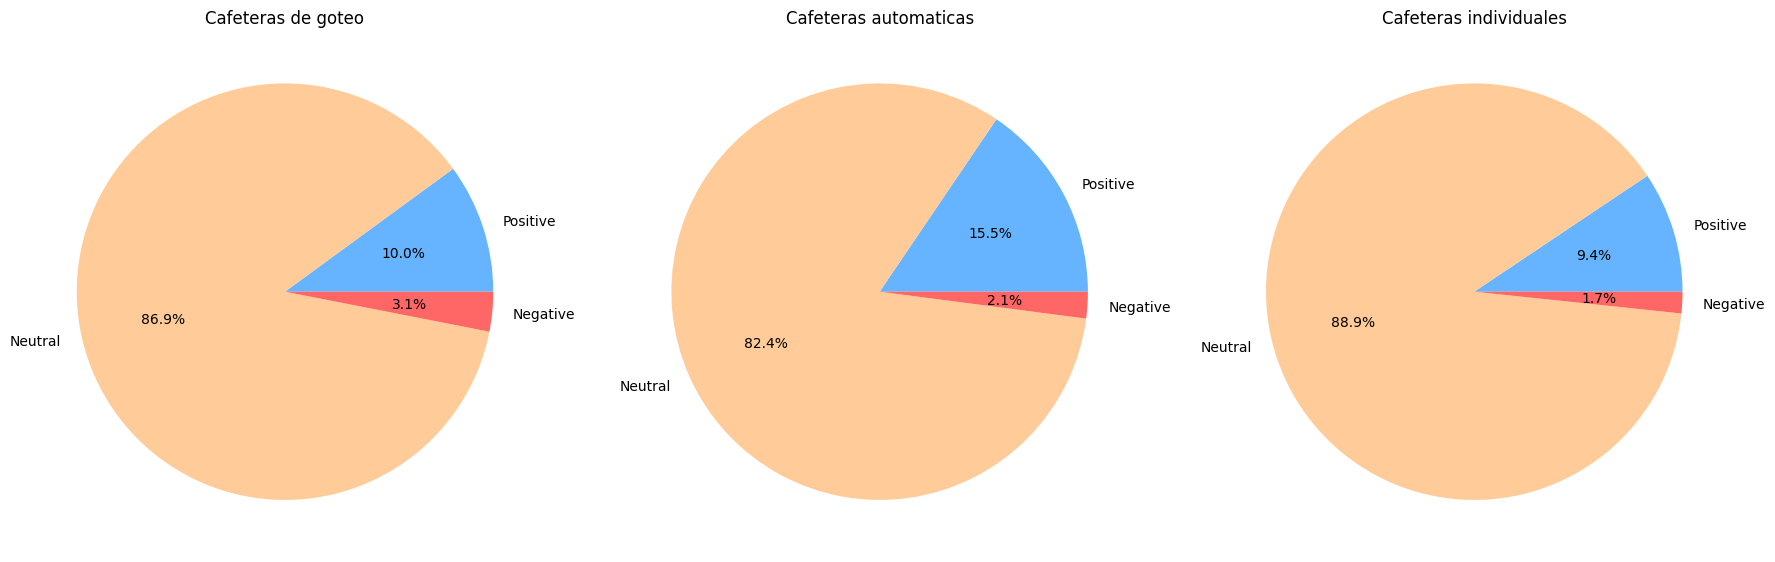

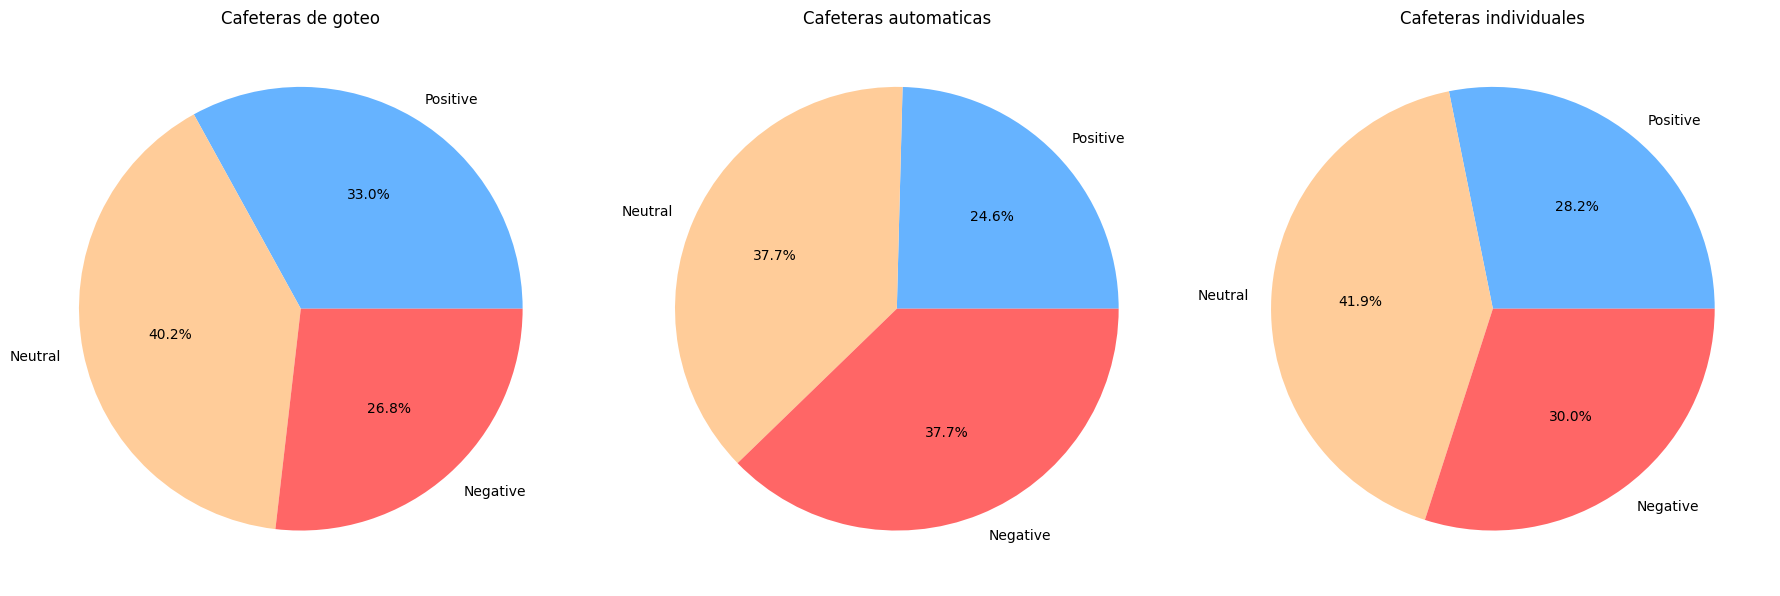

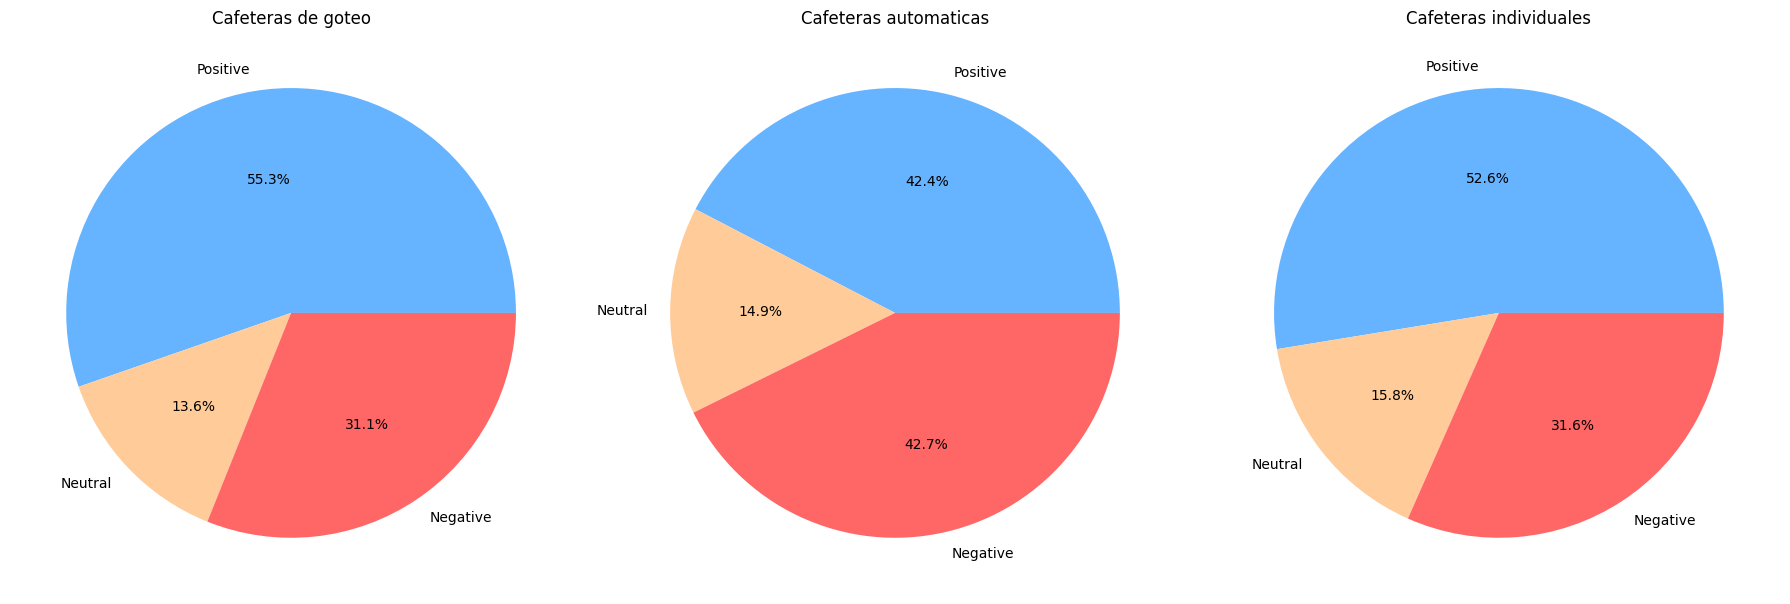

In [90]:
types = ['TextBlob_sentiment', 'Pysentimiento_sentiment', 'BERT_sentiment']

for i in range(3):
    polarities = load_polarities_from_csv(types[i])

    text = f'Resultado de {types[i]}:'
    html_code = f"""
    <b style="font-size: 20px;">
        <h1 style="font-size: 25px; text-align: center;">{text}</h1>
    </b>
    """
    display(HTML(html_code))

    show_pie_chart(polarities)
    

---
<b style="font-size: 20px;">
    Comparación de los métodos PySentimiento y BERT
</b>

In [104]:
show_comparison()

Review,Pysentimiento Sentiment,BERT Sentiment
me gusto mucho,NEU,POS
me encanta soy adicta al cafe y me gusta tomarme un buen espresso espumoso y cargado de sabor antes de comprar este modelo tenia el modelo anterior sin el acabado de madera y ha funcionado perfectamente durante años luego ha empezado a tener fallos de presion y he decidido cambiar a una cafetera carisima de delonghi dedica arte y es que no merecia la pena hacia el cafe menos intenso y el espumador de leche no servia para nada porque dejaba la leche igual de liquida y sin espuma he vuelto a create porque a parte de tener un diseño tan precioso hace un cafe maravilloso y el espumador de leche es una maravilla y todo eso por un precio tan reducido que no hace falta pagar cientos de euros por una cafetera que va a dar un resultado parecido lo recomiendo espero que esta con el uso y el cuidado adecuado dure mas de años,NEG,POS
un valle realmente bueno por el precio relativamente bajo,NEG,POS
la famosa cafetera delonghi creo que se han subido a la parra demasiado cara para ser gama baja este producto en cambio guarda una buena calidad precio y el resultado es mas que aceptable me la habian recomendado y creo que es un acierto,NEU,POS
ha llegado roto,NEU,NEG
me encanta desde el diseño hasta su funcionamiento todo de,NEU,POS
si la temperatura es demasiado alta cosa que se consigue con el vaporizador el cafe sale por fuera del cacillo si la temperatura es adequada hace un cafe buenisimo i es preciosa,POS,NEU
play video,NEU,POS
la compre para mi hija hace ya un par de meses y se lo he dado por su cumpleaños hoy y no es como lo esperaba no tiene la madera que se ve en las fotos,NEU,NEG
cuando la recibi me desilusiono tanto plastico el color me encanto pero funciona perfectamente y al cabo de los meses creo cada dia hace cafes con mas espuma nos gusta a toda la familia,NEU,POS


Review,Pysentimiento Sentiment,BERT Sentiment
funcion bastante bien con la salvedad del deposito para el cafe molido que a veces no va bien y sale solo agua perdiendose el cafe,NEG,NEU
muy buena cafetera es semiautomatica y como promete solo debes colocar el cafe en grano y agua ella de encarga del resto las configuraciones iniciales son algo mas engorrosas de lo normal pero considero adecuado para esta cafetera por el tipo en bastante customizable lo cual ayuda cuando son varios en la familia que toman cafe y el filtro de aguas que se ajusta a la dureza del agua de tu zona tambien se agradece mucho de resto mi unico punto negativo fue la caja del envio y que considero malgasta el cafe en grano o me dura menos no se por que el cafe en muy rico y tiende a tomar mas jajaja,NEU,POS
pues hace lo mismo que cualquier otra super automatica mucho mas barata el cafe pues solo notas de diferencia en grano que pongas asi que las opciones es una con mas agua o menos agua el deposito del cafe no esta bien organizado y se queda cafe en las esquinas o entre el selector y la pared del deposito consume mucha agua asi que los casi litros se van en nada ya que limpia a cada poco y hay que estar vaciando el deposito de agua si lo se me compro la krups,NEG,NEU
todo muy rapido y la cafetera un cafe espectacular por poner un pero cuando se enciende la cafetera tira agua,NEU,POS
me llego perfecta rapido vi comentarios de todas clases para mi gusto estoy muy contenta el ruido normal de una cafetera incluso menos de las de capsulas que tenia anterior el cafe de bueno segun lo compres si le pones uno malo claro que te saldra peor yo le pongo un grano de cafe que me gusta y me sale buenisimo la espuma super densa yo por mi parte estoy encantada doy un que a la cafetera,NEU,POS
estoy contenta con la cafetera porque el cafe sale muy bueno pero me da problemas desde el primer dia que la adquiri es decir hace un mes y medio,NEG,NEU
hay pocas instrucciones y de las pocas que hay ninguna en español seria necesario un video dando las instrucciones de programacion de todos sus componentes y como activarlos,NEU,NEG
excelente dispositivo pero hace mucho ruido y hay que vaciarlo rapidamente,NEG,POS
no se el resultado que dara a la larga pero de momento puedo decir que es una pasada de cafetera,NEU,NEG
este dispositivo funciono durante solo meses luego los granos de cafe ya no estaban molidos el reemplazo de lo que se trabajo un nuevo dispositivo durante meses mordiendo el agua solo termino en el recipiente de recoleccion en lugar de en la taza a pesar del nuevo dispositivo de reemplazo la garantia se referia a la primera compra y por lo tanto expiro ambos dispositivos fueron limpiados y esperados segun las instrucciones absolutamente ninguna recomendacion de compra nunca mas philips,NEU,NEG


Review,Pysentimiento Sentiment,BERT Sentiment
al usarla la encuentro extraordinariamente pequeña solo para una taza pequeña ruego me informen como hago para cambiarla a otra de mayor capacidad espero sus noticias,NEU,NEG
diseño con estilo facil de usar y vino con instrucciones buenas ocupa mucho menos espacio que la maquina que tenia antes pero un tamaño mas pequeño significa que hay que vaciar las capsulas antes solo caben mas o menos,NEU,POS
bueno es compacta y funciona bien lo unico parece que el cafe sale mas despacio que con mi otra maquina,NEU,POS
la cafetera esta va muy bien lo unico que lo de las capsulas de cafe es muy pequeña con o capsulas ya se llena el cajon pero eso es lo menos importante ya que hace un cafe buenisimo,NEU,POS
esta cafetera esta genial para los que no quieren una cafetera complicada tiene un boton y ya esta tu decides cuanto cafe quieres encendiendo y parando a tu gusto nada de programar la cantidad de agua y mas bobadas se enciende y se apaga con el mismo boton el deposito de agua es redonda y se puede limpiar con facilidad no como otros de formas exoticas en que ni siquiera puedes meter un cepillo el cafe de lavazza esta muy por encima del cafe de nescafe incluso las capsulas compatibles saben mejor y la cafetera funciona igual de bien compre la cafetera en amazon warehouse supuestamente de segunda mano pero en realidad era nueva y sin estrenar solo tenia una parte lateral un poco rayada apenas se notaba pero el precio obviamente a casi la mitad vale mucho la pena recomendable,NEU,POS
hola buenas acabo de recibirlo y he tenido problemas al iniciar la cafetera por primera vez aviso llenar el depósito de agua he tardado un rato en ponerla en marcha parecia que no cogia el agua y el error mio ha sido que tenia el deposito por la mitad en cuanto lo he llenado hasta arriba se ha puesto ha funcionar el producto es re acondicionado pero por el momento funcionamiento correcto,NEG,NEU
la maquina va perfecta no le doy las estrellas por el tipo de capsulas que usa,NEU,POS
la cafetera no funciona anteriormente tenia una igual e iba de maravilla pero esta no funciona porque no sale el agua del deposito y la maquina vibra muy fuerte la reemplace por otra identica y tiene el mismo problema un desastre la fecha de fabricacion que pone en la caja es del no se si tendra algo que ver y las capsulas sumistradas estan caducadas desde hace casi un año me encanta este cafe y este modelo de cafetera pero en este caso la compra ha sido un desastre pendiente aun del reembolso de amazon,NEG,NEU
el articulo me ha gustado mucho comprare mas unidades cuando salga la misma oferta,NEU,POS
pas solide,NEU,NEG
